# Single Scenario FaIR Model

### Below is E's code adapting N's to a single scenario run, and only using numpy calculations

In [372]:
## import required dependencies ##

import numpy as np
import pandas as pd
import numexpr as ne
import scipy as sp
import os
from tqdm import tqdm

## extra  libraries for graphing ##

import sys
import matplotlib.pyplot as plt
import seaborn as sn

In [373]:
##define the functions for using in running FaIR ##

def return_gas_namelist_e():
    
    gas_namelist = ['bc',
                    'bc|aci',
                    'bc|bc_on_snow',
                    'c2f6',
                    'c3f8',
                    'c4f10',
                    'c5f12',
                    'c6f14',
                    'c7f16',
                    'c8f18',
                    'c_c4f8',
                    'carbon_dioxide',
                    'carbon_tetrachloride',
                    'carbon_tetrachloride|o3',
                    'cf4',
                    'cfc11',
                    'cfc113',
                    'cfc113|o3',
                    'cfc114',
                    'cfc114|o3',
                    'cfc115',
                    'cfc115|o3',
                    'cfc11|o3',
                    'cfc12',
                    'cfc12|o3',
                    'ch2cl2',
                    'ch2cl2|o3',
                    'ch3ccl3',
                    'ch3ccl3|o3',
                    'chcl3',
                    'chcl3|o3',
                    'co',
                    'co|o3',
                    'halon1202',
                    'halon1202|o3',
                    'halon1211',
                    'halon1211|o3',
                    'halon1301',
                    'halon1301|o3',
                    'halon2402',
                    'halon2402|o3',
                    'hcfc141b',
                    'hcfc141b|o3',
                    'hcfc142b',
                    'hcfc142b|o3',
                    'hcfc22',
                    'hcfc22|o3',
                    'hfc125',
                    'hfc134a',
                    'hfc143a',
                    'hfc152a',
                    'hfc227ea',
                    'hfc23',
                    'hfc236fa',
                    'hfc245fa',
                    'hfc32',
                    'hfc365mfc',
                    'hfc4310mee',
                    'methane',
                    'methane|strat_h2o',
                    'methane|o3',
                    'methyl_bromide',
                    'methyl_bromide|o3',
                    'methyl_chloride',
                    'methyl_chloride|o3',
                    'nf3',
                    'nh3',
                    'nitrous_oxide',
                    'nitrous_oxide|o3',
                    'nmvoc',
                    'nmvoc|o3',
                    'nox',
                    'nox_avi',
                    'nox_avi|contrails',
                    'nox|o3',
                    'oc',
                    'oc|aci',
                    'sf6',
                    'so2',
                    'so2f2',
                    'so2|aci'
                   ]
    
    return gas_namelist

def get_gas_parameter_defaults_e(choose_gases=return_gas_namelist_e()):

# this is the file that contains all the default parameters for running FaIR #
    
    CHOOSE_params = pd.read_csv(("Complete_gas_cycle_params.csv"),header=[0,1],index_col=0).reindex(choose_gases,axis=1,level=1)

    return CHOOSE_params

def get_thermal_parameter_defaults_e(TCR=1.79,RWF=0.552,F_2x=3.759):

# these parameters are taken from the 2021 paper Leach et al: https://gmd.copernicus.org/articles/14/3007/2021/gmd-14-3007-2021.pdf #

    d1 = 0.903
    d2 = 7.92
    d3 = 355
    q1 = 0.180
    ECS = TCR/RWF

    v1 = (1-(d1/69.66) * (1-np.exp(-69.66/d1)) )
    v2 = (1-(d2/69.66) * (1-np.exp(-69.66/d2)) )
    v3 = (1-(d3/69.66) * (1-np.exp(-69.66/d3)) )

    q3 = (((TCR/F_2x) - q1*(v1-v2) - (ECS/F_2x)*v2) / (v3-v2))
    q2 = (ECS/F_2x - q1 -  q3)

    df = pd.DataFrame([[d1,d2,d3],[q1,q2,q3]],
                      index=['d','q'],
                      columns=pd.MultiIndex.from_product([['default'],[1,2,3]])
                     )

    return df.apply(pd.to_numeric)

def calculate_alpha_e(G,G_A,T,r,g0,g1,iirf100_max = False):

# iirf100 is the average airborne fraction of the gases considered over a period of 100 years #
    
    iirf100_val = r[...,0] + r[...,1] * (G-G_A) + r[...,2] * T + r[...,3] * G_A 
    
    if iirf100_max:
        
        if iirf100_val>iirf100_max:
            
            iirf100_val=iirf100_max

# alpha is the statedependent timescale adjustment factor; it scales the decay timescales of the gases considered, allowing for the effective sink from the atmosphere to change in strength over time #
    
    alpha_val = g0 * np.exp(iirf100_val / g1)

    return alpha_val

def step_forcing_e(C,PI_conc,f):

    RF=np.zeros_like(C)

    for i in range(len(C)):

# the logarithmic, linear, and square root forcing components are calculated and then summed to find the total realtive forcing for each gas [i] #
        
        if (C[i]/PI_conc[i]) <= 0:
            
            logforc=0
        else:
            
            logforc=f[i,0]*np.log(C[i]/PI_conc[i])

        linforc = f[i,1] * (C[i] - PI_conc[i])
    
        if C[i]<0:
            
           sqrtforc = f[i,2] * (np.sqrt(0) - np.sqrt(PI_conc[i]))
            
        else:
            
           sqrtforc = f[i,2] * (np.sqrt(C[i]) - np.sqrt(PI_conc[i]))
            
        RF[i] = logforc + linforc + sqrtforc
        
    return RF


def return_empty_emissions_e(df_to_copy=False, start_year=1765, end_year=2500, timestep=1, gases_in = return_gas_namelist_e()):

# formatting a pandas dataframe that is empty, ready to be filled with emissions #
    
    if type(df_to_copy)==pd.core.frame.DataFrame:
        
        df = pd.DataFrame(index = df_to_copy.index,
                          columns=pd.MultiIndex.from_product([gases_in],
                                                             names=['Gas']
                                                            )
                         ).fillna(0).apply(pd.to_numeric)
        
    else:

        df = pd.DataFrame(index=np.arange(start_year,end_year+1,timestep),
                          columns=pd.MultiIndex.from_product([gases_in],
                                                             names=['Gas']
                                                            )
                         ).fillna(0).apply(pd.to_numeric)
        df.index.rename('Year',inplace=True)

    return df

def return_empty_forcing_e(df_to_copy=False, start_year=1765, end_year=2500, timestep=1):

# formatting a pandas dataframe that is empty, ready to be filled with forcing #
    
    if type(df_to_copy)==pd.core.frame.DataFrame:
        
        df = pd.DataFrame(index = df_to_copy.index,
                          columns=pd.MultiIndex.from_product([['forcing']],
                                                             names=['Variable']
                                                            )
                         ).fillna(0).apply(pd.to_numeric)
        
    else:
        
        df = pd.DataFrame(index=np.arange(start_year,end_year+1,timestep),
                          columns=pd.MultiIndex.from_product([['forcing']],
                                                             names=['Gas']
                                                            )
                         ).fillna(0).apply(pd.to_numeric)
        df.index.rename('Year',inplace=True)

    return df

def step_temperature_e(S_old,F,q,d,dt=1):

    decay_factor = np.exp(-dt/d)
    S_new = q * F['forcing'] * (1 - decay_factor) + S_old * decay_factor # if not pandas dataframe will need to not reference by title 'forcing'
    T = np.sum((S_old + S_new)/2)

    return S_new,T

def step_concentration_e(R_old,G_A_old,E,alpha,a,tau,PI_conc,emis2conc,dt=1):

    R_new=np.zeros_like(a)
    
    for x in range(len(a[0])): # number of boxes, 4 at the moment, but this needs to be the same as tau
        
        for i in range(len(alpha)): # number of gases
            
            decay_rate = dt/(alpha[i]*tau[i,x])
            decay_factor = np.exp(-decay_rate)
            R_new[i,x] = E[i] * a[i,x] / decay_rate * ( 1. - decay_factor ) + R_old[i,x] * decay_factor # there shouldn't be a dt in the first decay rate
   
    G_A = np.sum(R_new, axis=-1)
    C = PI_conc + emis2conc * (G_A + G_A_old) / 2
    
    return C,R_new,G_A

def unstep_concentration_e(R_old,G_A,alpha,a,tau,dt=1):

    decay_rate = dt/(alpha*tau)
    decay_factor = np.exp(-decay_rate)
    E = (( G_A - np.sum(R_old *decay_factor,axis=-1) ) / np.sum( a / decay_rate * ( 1. - decay_factor ), axis=-1 )) # errr maybe spotted : changing value of E each cycle?
    R_new = E * a / decay_rate * ( 1. - decay_factor ) + R_old * decay_factor # there shouldn't be a dt in the first decay rate

    return E,R_new

def invert_carbon_cycle_prescribed_T(C,T,a,tau,r,PI_conc,emis2conc):

   g1 = np.sum( a * tau * ( 1. - ( 1. + 100/tau ) * np.exp(-100/tau) ), axis=-1)
   g0 = np.exp( -1 * np.sum( a * tau * ( 1. - np.exp(-100/tau) ) , axis=-1) / g1 )

   diagnosed_emissions = np.zeros(C.size)
   alpha = np.zeros(C.size)
   G_A = (np.array([np.mean(C[i:i+2]) for i in np.arange(C.size)])-PI_conc)/emis2conc
   G_A[-1]=2*G_A[-1]-G_A[-2]

   alpha[0] = calculate_alpha_e(G=0,G_A=0,T=0,r=r,g0=g0,g1=g1)
   diagnosed_emissions[0],R = unstep_concentration_e(R_old=np.zeros_like(a),G_A=G_A[0],alpha=alpha[0,np.newaxis],a=a,tau=tau)
   for t in np.arange(1,C.size):
       G = np.sum(diagnosed_emissions)
       alpha[t] = calculate_alpha_e(G=G,G_A=G_A[t-1],T=T[t-1],r=r,g0=g0,g1=g1)
       diagnosed_emissions[t],R = unstep_concentration_e(R_old=R,G_A=G_A[t],alpha=alpha[t,np.newaxis],a=a,tau=tau)

   return pd.Series(index=np.arange(C.size),data=diagnosed_emissions)


In [374]:
def run_FaIR_e (emissions_in=False,
             ext_forcing=False,
             concentrations_in=False, 
             gas_parameters=get_gas_parameter_defaults_e(),
             thermal_parameters=get_thermal_parameter_defaults_e(),
             iirf100_max=False):


    if emissions_in is False: 
        concentration_driven = True
        emissions_in = pd.DataFrame().reindex_like(concentrations_in)
        ext_forcing = return_empty_forcing_e(df_to_copy=concentrations_in)
        time_index = concentrations_in.index
    else: 
        concentration_driven=False
        ext_forcing = return_empty_forcing_e(df_to_copy=emissions_in)
        time_index = emissions_in.index
    
    [(gas_set_names),(thermal_set_names)]=[(list(x)) for x in [gas_parameters.columns.levels[0],thermal_parameters.columns.levels[0]]]

    gas_names = [x for x in gas_parameters.columns.levels[1] if '|' not in x]
    n_gas = len(gas_names)
    n_forc,forc_names = gas_parameters.columns.levels[1].size,list(gas_parameters.columns.levels[1])
    n_year = len(time_index)

    timestep = np.append(np.diff(time_index),np.diff(time_index)[-1]) ## finds the discrete difference between each timestep

    a,tau,r,PI_conc,emis2conc=[gas_parameters.loc[x].values.T for x in [['a1','a2','a3','a4'],['tau1','tau2','tau3','tau4'],['r0','rC','rT','rA'],'PI_conc','emis2conc']]
    d,q = [thermal_parameters.loc[x].values.T for x in ['d','q']]
    f = gas_parameters.loc['f1':'f3'].values.T

    g1 = np.sum( a * tau * ( 1. - ( 1. + 100/tau ) * np.exp(-100/tau) ), axis=-1 )
    g0 = np.exp( -1 * np.sum( a * tau * ( 1. - np.exp(-100/tau) ) , axis=-1) / g1 ) 

    C = np.empty((n_gas,n_year))
    RF = np.empty((n_forc,n_year))
    T = np.empty((n_year))
    alpha = np.empty((n_gas,n_year))
    alpha[...,0] = calculate_alpha_e(G=0,G_A=0,T=0,r=r,g0=g0,g1=g1)

    
    names_list = [gas_set_names,thermal_set_names,gas_names]
    names_titles = ['Gas cycle set','Thermal set','Gas name']
    forc_names_list = [gas_set_names,thermal_set_names,forc_names]
    forc_names_titles = ['Gas cycle set','Thermal set','Forcing component']

    if concentration_driven:

        diagnosed_emissions = np.zeros((n_gas,n_year))

        diagnosed_ocean = np.zeros((n_gas,n_year))

        R_old = np.zeros((concentrations_in.iloc[0].size,a.size))
        
        C[:] = concentrations_in.T

        G_A = np.zeros_like(C)
        
        G_A[...,:-1] = concentrations_in.rolling(2).mean().dropna().values.T.reshape(n_gas,n_year-1)
        
        G_A[...,-1] = G_A[...,-2] + (C[...,-1]-C[...,-2]) #same as axis of summation, back to front
        
        G_A = (G_A-PI_conc)/emis2conc

        T=np.zeros(n_year)
        
        RF[...,0] = step_forcing_e(C=C[...,0],PI_conc=PI_conc,f=f) ## here i am chaning the formatting of RF to be variable over time, as for emissions inputs
        
        diagnosed_emissions[...,0],R = unstep_concentration_e(R_old=R_old,G_A=G_A[...,0],alpha=alpha[...,0,np.newaxis],a=a,tau=tau,dt=timestep[0])
        
        S,T[...,0] = step_temperature_e(S_old=0,F=np.sum(RF[...,0],axis=-1)[...,np.newaxis]+ext_forcing.iloc[0],q=q,d=d,dt=timestep[0])

        for t in tqdm(np.arange(1,n_year),unit=' timestep'):
            
            G = np.sum(diagnosed_emissions,axis=-1)
            
            alpha[...,t] = calculate_alpha_e(G=G,G_A=G_A[...,t-1],T=np.sum(S,axis=-1)[...,np.newaxis],r=r,g0=g0,g1=g1)

            diagnosed_emissions[...,t],R = unstep_concentration_e(R_old=R,G_A=G_A[...,t],alpha=alpha[...,t,np.newaxis],a=a,tau=tau,dt=timestep[t])

            RF[...,t] = step_forcing_e(C=C[...,t],PI_conc=PI_conc,f=f)
            
            S,T[...,t] = step_temperature_e(S_old=S,F=np.sum(RF[...,t],axis=-1)[...,np.newaxis]+ext_forcing.iloc[t],q=q,d=d,dt=timestep[t])

        C_out = concentrations_in.copy()
        
        E_out = pd.DataFrame(np.moveaxis(diagnosed_emissions,-1,0).reshape(diagnosed_emissions.shape[-1],-1),index = time_index,columns=pd.MultiIndex.from_product(names_list,names=names_titles))

    if not concentration_driven:
        
        G = np.cumsum(emissions_in)

        diagnosed_ocean = np.zeros((n_gas,n_year))

        R_old = np.zeros((emissions_in.iloc[0].size,4))
    
        C[...,0],R,G_A = step_concentration_e(R_old = R_old,G_A_old = 0,alpha=alpha[...,0,np.newaxis],E=emissions_in.iloc[0],a=a,tau=tau,PI_conc=PI_conc,emis2conc=emis2conc[...,0],dt=timestep[0])
                        
        RF[...,0] = step_forcing_e(C=C[...,0],PI_conc=PI_conc,f=f)
        
        S,T[...,0] = step_temperature_e(S_old=0,F=np.sum(RF[...,0],axis=-1)[...,np.newaxis]+ext_forcing.iloc[0],q=q,d=d,dt=timestep[0])
                
        for t in tqdm(np.arange(1,n_year),unit=' timestep'):

            alpha[...,t] = calculate_alpha_e(G=G.iloc[t-1],G_A=G_A,T=np.sum(S,axis=-1)[...,np.newaxis],r=r,g0=g0,g1=g1)
            
            C[...,t],R,G_A = step_concentration_e(R_old = R,G_A_old=G_A,alpha=alpha[...,t,np.newaxis],E=emissions_in.iloc[t],a=a,tau=tau,PI_conc=PI_conc,emis2conc=emis2conc[...,0],dt=timestep[t])
            
            RF[...,t] = step_forcing_e(C=C[...,t],PI_conc=PI_conc,f=f)
            
            S,T[...,t] = step_temperature_e(S_old=S,F=np.sum(RF[...,t],axis=-1)[...,np.newaxis]+ext_forcing.iloc[t],q=q,d=d,dt=timestep[t])
            
        C_out = pd.DataFrame(np.moveaxis(C,-1,0).reshape(C.shape[-1],-1),index = time_index,columns=pd.MultiIndex.from_product(names_list,names=names_titles))
        
        E_out = emissions_in.copy()

    inverted_carbon_cycle_emissions = np.empty((n_gas,n_year))

    inverted_carbon_cycle_emissions = invert_carbon_cycle_prescribed_T(C_out,T,a,tau,r,PI_conc,emis2conc)

    ext_forcing = ext_forcing.T
    RF = np.concatenate((RF,ext_forcing),axis=0) #stuck together like stacks of paper
    RF = np.concatenate((RF,np.sum(RF,axis=0)[...,np.newaxis,:]),axis=0) #total is total of co2 + methane + external for each timestep, is this what we wanted?
    
    alpha_out = pd.DataFrame(np.moveaxis(alpha,-1,0).reshape(alpha.shape[-1],-1),index = time_index,columns=pd.MultiIndex.from_product(names_list,names=names_titles))
    RF_out = pd.DataFrame(np.moveaxis(RF,-1,0).reshape(RF.shape[-1],-1),index = time_index,columns=pd.MultiIndex.from_product([x+['External','Total']*(x==forc_names_list[-1]) for x in forc_names_list],names=forc_names_titles))
    T_out = pd.DataFrame(np.moveaxis(T,-1,0).reshape(T.shape[-1],-1),index = time_index,columns=pd.MultiIndex.from_product(names_list[:-1],names=names_titles[:-1]))
    inverted_carbon_cycle_emissions_out = pd.DataFrame(inverted_carbon_cycle_emissions, index = time_index,columns=pd.MultiIndex.from_product(names_list,names=names_titles))


    out_dict = {'C_e':C_out, \
                'RF_e':RF_out, \
                'T_e':T_out, \
                'alpha_e':alpha_out, \
                'Emissions_e':E_out , \
                'gas_parameters_e':gas_parameters , \
                'thermal_parameters_e':thermal_parameters}

    for axis in [x for x in list(out_dict.keys())[:-2] if type(x)==pd.core.frame.DataFrame]:
        out_dict[axis].index = out_dict[axis].index.rename('Year')

    return out_dict


/var/folders/dd/n_9wp4x11tn45bzqgcwvt_pr0000gp/T/ipykernel_37045/62417601.py:188: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(0).apply(pd.to_numeric)
/var/folders/dd/n_9wp4x11tn45bzqgcwvt_pr0000gp/T/ipykernel_37045/62417601.py:203: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(0).apply(pd.to_numeric)
/var/folders/dd/n_9wp4x11tn45bzqgcwvt_pr0000gp/T/ipykernel_37045/62417601.py:234: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent w

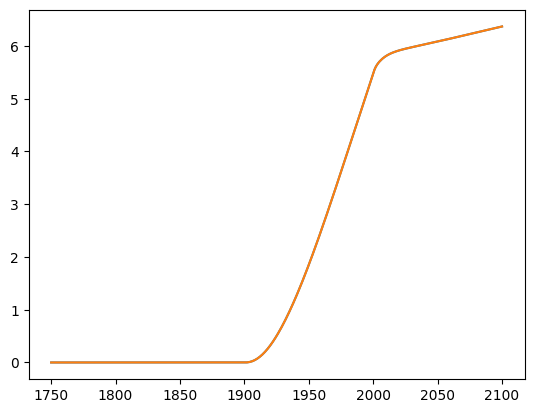

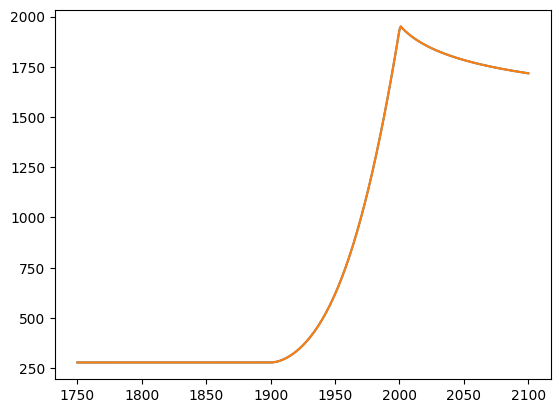

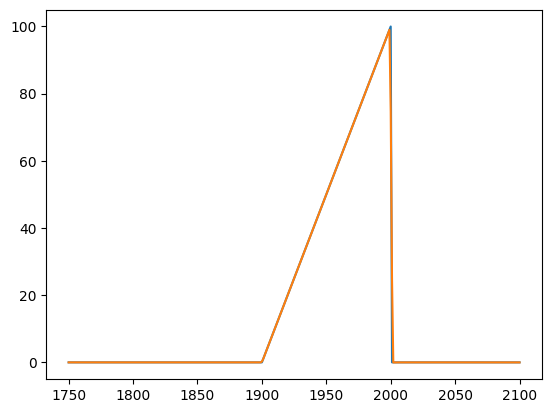

In [375]:
test_ems = return_empty_emissions_e(start_year=1750, end_year=2100, gases_in=['carbon_dioxide'])
test_ems.loc[1900:2000,('carbon_dioxide')] = np.arange(0,101)

gas_params = get_gas_parameter_defaults_e(choose_gases=['carbon_dioxide'])
therm_params = get_thermal_parameter_defaults_e()
out = run_FaIR_e(emissions_in=test_ems, gas_parameters=gas_params, thermal_parameters=therm_params)

concs_in = return_empty_emissions_e(start_year=1750, end_year=2100, gases_in=['carbon_dioxide'])
concs_in.loc[1750:2100,('carbon_dioxide')] = out['C_e'].loc[:,('default','default', 'carbon_dioxide')].values

out_2 = run_FaIR_e(concentrations_in=concs_in, gas_parameters=gas_params, thermal_parameters=therm_params)
plt.plot(out['T_e'])
plt.plot(out_2['T_e'])

plt.figure()
plt.plot(out['C_e'])
plt.plot(out_2['C_e'])

plt.figure()
plt.plot(out['Emissions_e'])
plt.plot(out_2['Emissions_e'])

In [376]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

cc_tuning_fairpaper = pd.read_csv(("CMIP6_cc_full.csv")) # cc_full
therm_tuning_fairpaper = pd.read_csv(("CMIP6_climresp.csv")) # _climresp
therm_tuning_fairpaper_f = pd.read_csv(("CMIP6_f_params.csv")) #f_params

from scipy.optimize import minimize as min_calc
from scipy.optimize import curve_fit

In [377]:
tas_access_1000 = pd.read_csv('all_zecmip/ACCESS/ACCESS_A1/tas_ACCESS-ESM1.5_esm-1pct-brch-1000PgC_68-167.csv', index_col=0)
conc_access_1000 = pd.read_csv('all_zecmip/ACCESS/ACCESS_A1/co2_ACCESS-ESM1.5_esm-1pct-brch-1000PgC_68-167.csv', index_col=0)

/var/folders/dd/n_9wp4x11tn45bzqgcwvt_pr0000gp/T/ipykernel_37045/62417601.py:264: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  alpha[t] = calculate_alpha_e(G=G,G_A=G_A[t-1],T=T[t-1],r=r,g0=g0,g1=g1)


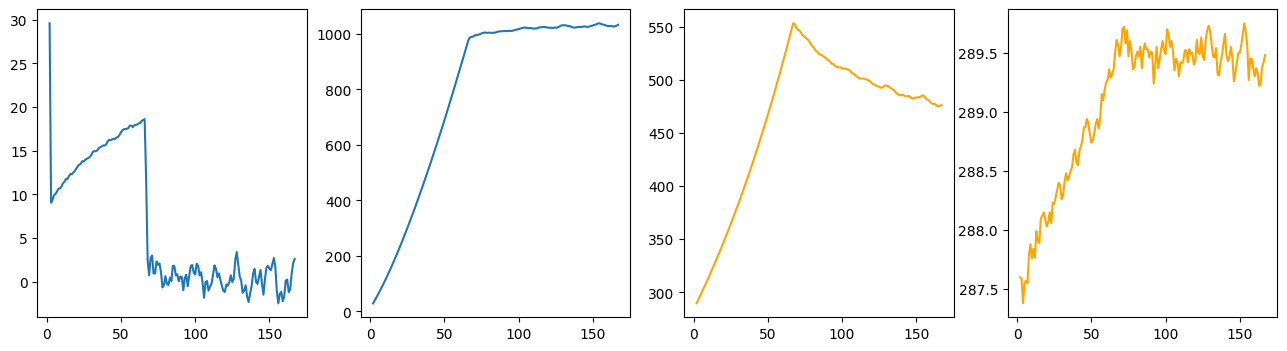

In [378]:
fig, ax = plt.subplots(1,4,figsize=(16,4))

gas_params = get_gas_parameter_defaults_e(choose_gases=['carbon_dioxide'])

gas_params.loc[:,('default','carbon_dioxide')].a1 -= 0.1
gas_params.loc[:,('default','carbon_dioxide')].a2 -= 0.1
gas_params.loc[:,('default','carbon_dioxide')].a3 += 0.1
gas_params.loc[:,('default','carbon_dioxide')].a4 += 0.1

a = gas_params.iloc[:4].values.squeeze()
tau = gas_params.iloc[4:8].values.squeeze()
r = gas_params.iloc[8:12].values.squeeze()
pi_conc = gas_params.iloc[12].values.squeeze()
emis2conc = gas_params.iloc[13].values.squeeze()

r[0] = cc_tuning_fairpaper['ACCESS-ESM1-5'][0]
r[1] = cc_tuning_fairpaper['ACCESS-ESM1-5'][1]
r[2] = cc_tuning_fairpaper['ACCESS-ESM1-5'][2]
r[3] = cc_tuning_fairpaper['ACCESS-ESM1-5'][3]

onepc_ems = invert_carbon_cycle_prescribed_T(conc_access_1000.values,tas_access_1000.values-np.mean(tas_access_1000.values[0:5]),a,tau,r,pi_conc,emis2conc)
ax[0].plot(conc_access_1000.index.values, onepc_ems)
ax[1].plot(conc_access_1000.index.values, np.cumsum(onepc_ems))

ax[2].plot(conc_access_1000.index.values, conc_access_1000.values, color='orange')
ax[3].plot(tas_access_1000.index.values, tas_access_1000.values, color='orange')

In [379]:
nbp_access_1000 = pd.read_csv('all_zecmip/ACCESS/ACCESS_A1/nbp_ACCESS-ESM1.5_esm-1pct-brch-1000PgC_68-167.csv', index_col=0)
fgco2_access_1000 = pd.read_csv('all_zecmip/ACCESS/ACCESS_A1/fgco2_ACCESS-ESM1.5_esm-1pct-brch-1000PgC_68-167.csv', index_col=0)

/var/folders/dd/n_9wp4x11tn45bzqgcwvt_pr0000gp/T/ipykernel_37045/62417601.py:188: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(0).apply(pd.to_numeric)
/var/folders/dd/n_9wp4x11tn45bzqgcwvt_pr0000gp/T/ipykernel_37045/1628310564.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 8.329600e+00  1.074208e+01  9.977040e+00  1.060076e+01  1.187324e+01
  9.678200e+00  9.570680e+00  1.040564e+01  1.104936e+01  1.210308e+01
  1.192680e+01  1.307052e+01  1.413424e+01  1.208920e+01  1.293292e+01
  1.433788e+01  1.537036e+01  1.460656e+01  1.462904e+01  1.505400e+01
  1.660896e+01  1.399268e+01  1.499764e+01  1.506136e+01  1.466632e+01
  1.532004e+01  1.556624e+01  1.634996e+01  1.637492e+01  1.644

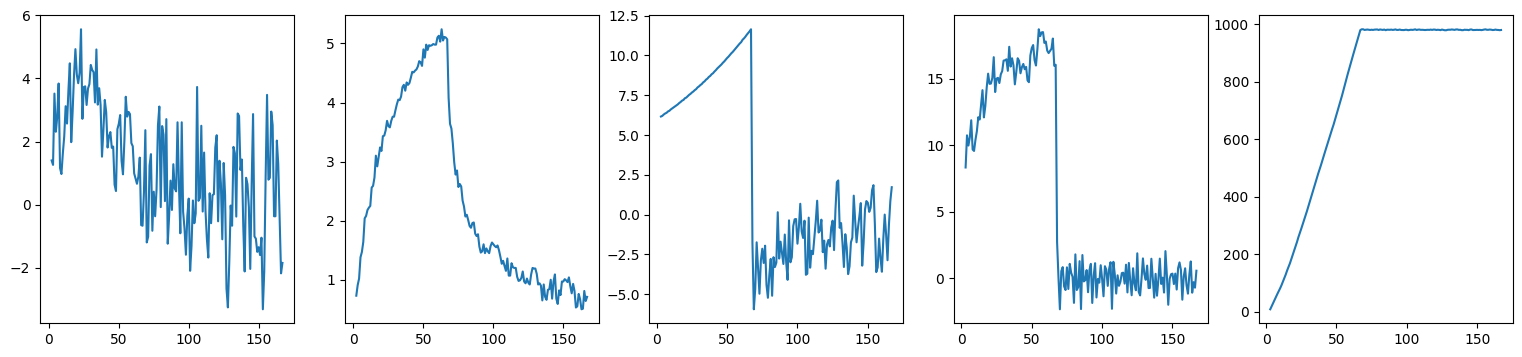

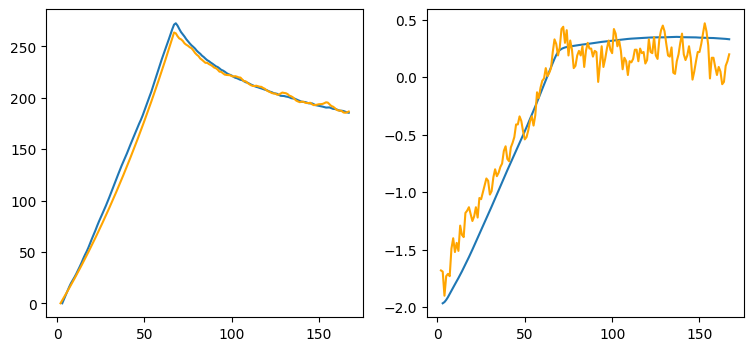

In [380]:
G_atm_cum = (conc_access_1000.values - conc_access_1000.values[0])*2.124
G_atm = (G_atm_cum - np.roll(G_atm_cum,1))[1:]

E_FF = G_atm + fgco2_access_1000.values[1:] + nbp_access_1000.values[1:] #emissions = atmospheric burden + surface downward flux between ocean and atm + net downward flux due to biosphere processes

fig, ax = plt.subplots(1,5,figsize=(19,4))
fig2, ax2 = plt.subplots(1,2,figsize=(9,4))

ax[0].plot(nbp_access_1000.index.values, nbp_access_1000.values)
ax[1].plot(fgco2_access_1000.index.values, fgco2_access_1000.values)
ax[2].plot(conc_access_1000.index.values[1:], G_atm)
ax[3].plot(conc_access_1000.index.values[1:], E_FF)
ax[4].plot(conc_access_1000.index.values[1:], np.cumsum(E_FF))

ems = return_empty_emissions_e(start_year=conc_access_1000.index.values[1], end_year=conc_access_1000.index.values[-1], gases_in=['carbon_dioxide'])
ems.loc[:,('carbon_dioxide')] = E_FF

gas_params.loc[:,('default','carbon_dioxide')].PI_conc = conc_access_1000.values[0]
gas_params.loc[:,('default','carbon_dioxide')].r0 = cc_tuning_fairpaper['ACCESS-ESM1-5'][0]
gas_params.loc[:,('default','carbon_dioxide')].rC = cc_tuning_fairpaper['ACCESS-ESM1-5'][1]
gas_params.loc[:,('default','carbon_dioxide')].rT = cc_tuning_fairpaper['ACCESS-ESM1-5'][2]
gas_params.loc[:,('default','carbon_dioxide')].rA = cc_tuning_fairpaper['ACCESS-ESM1-5'][3]

therm_params = get_thermal_parameter_defaults_e()
therm_params.loc[:,('default',1)].d = therm_tuning_fairpaper.filter(like='ACCESS-ESM1-5').loc[1][0]
therm_params.loc[:,('default',2)].d = therm_tuning_fairpaper.filter(like='ACCESS-ESM1-5').loc[1][1]
therm_params.loc[:,('default',3)].d = therm_tuning_fairpaper.filter(like='ACCESS-ESM1-5').loc[1][2]

therm_params.loc[:,('default',1)].q = therm_tuning_fairpaper.filter(like='ACCESS-ESM1-5').loc[2][0]
therm_params.loc[:,('default',2)].q = therm_tuning_fairpaper.filter(like='ACCESS-ESM1-5').loc[2][1]
therm_params.loc[:,('default',3)].q = therm_tuning_fairpaper.filter(like='ACCESS-ESM1-5').loc[2][2]

out_forwards = run_FaIR_e(emissions_in=ems, gas_parameters=gas_params, thermal_parameters=therm_params)

ax2[0].plot(out_forwards['C_e'] - out_forwards['C_e'].values[0])
ax2[1].plot(out_forwards['T_e'] - np.mean(out_forwards['T_e'].values[1911-1851-9:1911-1851+10]))

ax2[0].plot(conc_access_1000.index.values, conc_access_1000.values - conc_access_1000.values[0], color='orange')
ax2[1].plot(tas_access_1000.index.values, tas_access_1000.values - np.mean(tas_access_1000.values[1911-1851-9:1911-1851+10]), color='orange')

a = gas_params.loc[:,('default','carbon_dioxide')].values[:4]
tau = gas_params.loc[:,('default','carbon_dioxide')].values[4:8]
pi_conc = 0 #gas_params.loc[:,('default','carbon_dioxide')].PI_conc
emis2conc = gas_params.loc[:,('default','carbon_dioxide')].emis2conc
r0 = gas_params.loc[:,('default','carbon_dioxide')].values[8:12]

ems_to_aim_for = np.zeros(E_FF.size + 1)
ems_to_aim_for[1:] = E_FF[:,0]
ems_to_aim_for[0] = E_FF[0,0]

def cc_tuning_func(x,C,T,ems_to_aim_for,a,r0,tau,pi_conc,emis2conc):
    
    r = np.zeros_like(r0)
    r[0] = r0[0]*x[0]
    r[1] = r0[1]*x[1]#*x[1]
    r[2] = r0[2]*x[2]#*x[1]
    r[3] = 0.0#r0[3]*x[0]*x[2]
    
    out_ems = invert_carbon_cycle_prescribed_T(C,T,a,tau,r,pi_conc,emis2conc)
    
    return np.sum(np.abs(out_ems - ems_to_aim_for)**2)

args_to_input = (conc_access_1000.values, tas_access_1000.values - tas_access_1000.values[0], ems_to_aim_for, a, tau, r0, pi_conc, emis2conc)

test_run = min_calc(cc_tuning_func, x0=[1,1,1], args=args_to_input)

/var/folders/dd/n_9wp4x11tn45bzqgcwvt_pr0000gp/T/ipykernel_37045/62417601.py:264: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  alpha[t] = calculate_alpha_e(G=G,G_A=G_A[t-1],T=T[t-1],r=r,g0=g0,g1=g1)
/var/folders/dd/n_9wp4x11tn45bzqgcwvt_pr0000gp/T/ipykernel_37045/62417601.py:264: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  alpha[t] = calculate_alpha_e(G=G,G_A=G_A[t-1],T=T[t-1],r=r,g0=g0,g1=g1)


[-0.34807646  9.8910318  -4.97502634]
[-12.78782318   0.34572697 -15.10742312   0.        ]


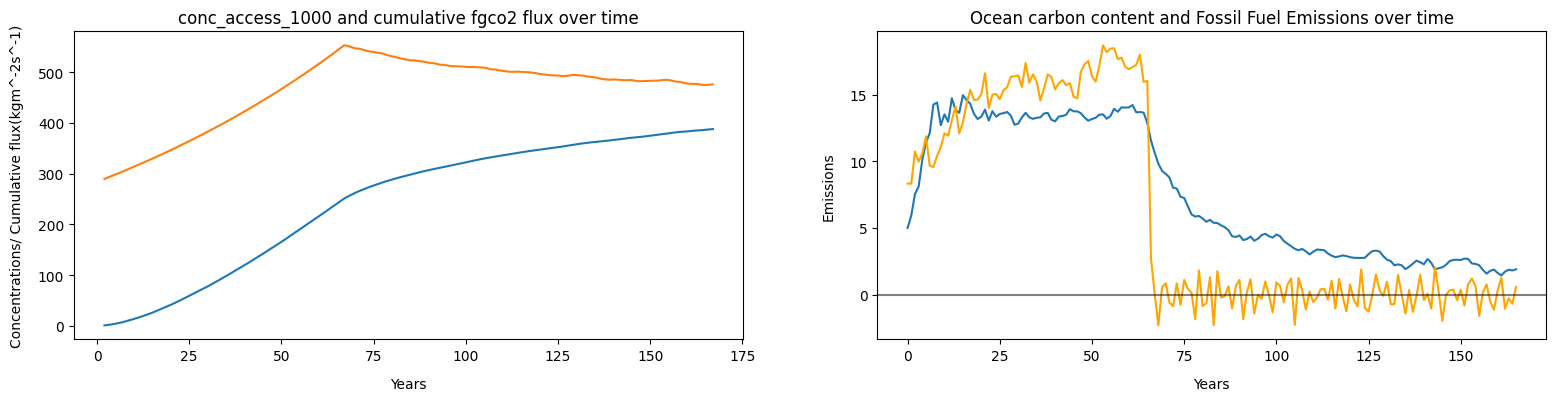

In [381]:
# C,T,r0,a,tau,pi_conc,emis2conc

def only_leave_params_to_be_set(x, alpha, beta, gamma):
    r = np.zeros_like(r0)
    r[0] = r0[0]*alpha
    r[1] = r0[1]*beta#alpha*beta
    r[2] = r0[2]*gamma#alpha*beta
    r[3] = 0.0#r0[3]*alpha*gamma
    
    ems_returned = invert_carbon_cycle_prescribed_T(x[0],x[1],a,tau,r,pi_conc,emis2conc).values
#     ems_returned[69:] = 0.0
    return ems_returned
    
nbp_access_1000 = pd.read_csv('all_zecmip/ACCESS/ACCESS_A1/nbp_ACCESS-ESM1.5_esm-1pct-brch-1000PgC_68-167.csv', index_col=0)
fgco2_access_1000 = pd.read_csv('all_zecmip/ACCESS/ACCESS_A1/fgco2_ACCESS-ESM1.5_esm-1pct-brch-1000PgC_68-167.csv', index_col=0)
F = fgco2_access_1000 # units: kg m^-2 s^-1
C=np.cumsum(F)

x = [C.values, (tas_access_1000.values - tas_access_1000.values[0])]

test, test2 = curve_fit(only_leave_params_to_be_set, x, ems_to_aim_for)

r = np.zeros_like(r0)
r[0] = r0[0]*test[0]
r[1] = r0[1]*test[1]#*test[1]
r[2] = r0[2]*test[2]#*test[1]
r[3] = 0.0#r0[3]*test[0]*test[2]

fig, ax = plt.subplots(1,2,figsize=(19,4))
ax[0].plot(C)
conc_access_1000 = pd.read_csv('all_zecmip/ACCESS/ACCESS_A1/co2_ACCESS-ESM1.5_esm-1pct-brch-1000PgC_68-167.csv', index_col=0)
ax[0].plot(conc_access_1000)

ax[1].plot(only_leave_params_to_be_set(x, test[0], test[1], test[2]))
ax[1].plot(ems_to_aim_for, 'orange')
ax[1].axhline(y=0, color='black', alpha=0.5)
ax[0].set_xlabel('Years', labelpad=10, fontsize=10, color='black')
ax[0].set_ylabel('Concentrations/ Cumulative flux(kgm^-2s^-1)', labelpad=10, fontsize=10, color='black')
ax[1].set_xlabel('Years', labelpad=10, fontsize=10, color='black')
ax[1].set_ylabel('Emissions', labelpad=10, fontsize=10, color='black')
ax[0].set_title('conc_access_1000 and cumulative fgco2 flux over time', fontsize=12, color='black')
ax[1].set_title('Ocean carbon content and Fossil Fuel Emissions over time',  fontsize=12, color='black')
#ocean carbon content shape doesn't have sharp turning point, ideas!!
plt.savefig('ACCESS_graphs.png')

print(test)
print(r)

100%|███████████████████████████████| 165/165 [00:00<00:00, 67373.46 timestep/s]

Optimised Parameters:
alpha: 1.3017634770200064, beta: 1.583890630614803, gamma: 8.7048401380944


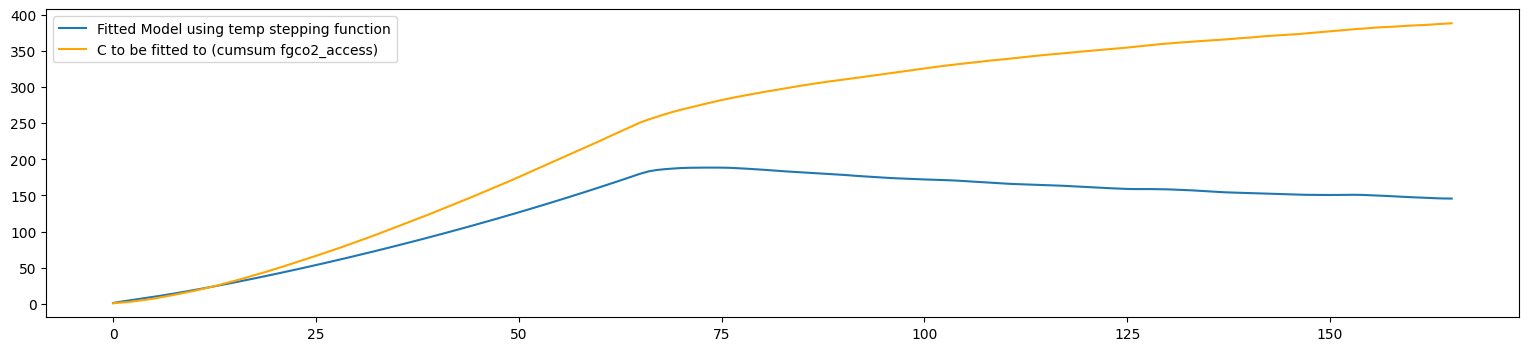

[1.30176348 1.58389063 8.70484014]


In [382]:
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# step temperature function
def step_temperature_e(S_old, F, q, d, dt=1):
    decay_factor = np.exp(-dt / d)
    S_new = q * F * (1 - decay_factor) + S_old * decay_factor
    T = np.sum((S_old + S_new) / 2)
    return S_new, T

# fitting parameters
def only_leave_params_to_be_set(time, alpha, beta, gamma, d_test = np.array([1,8,355])):
    q_test = np.array([0.2 * alpha, 0.3 * beta, 0.4 * gamma]) # initial guess
    
    C_test_values = np.array(conc_access_1000 - 280, dtype = float)
    C_output = np.zeros(len(C_test_values), dtype=float)
    
    S_test, C_output[0] = step_temperature_e(S_old=0, F=np.sum(C_test_values[0]), q=q_test, d=d_test, dt=1)
    
    for t in tqdm(range(1, len(time)), unit=' timestep'):
        S_test, C_output[t] = step_temperature_e(S_old=S_test, F=np.sum(C_test_values[t]), q=q_test, d=d_test, dt=1)
        
    return C_output.astype(float)

# conc data
conc_access_1000 = pd.read_csv('all_zecmip/ACCESS/ACCESS_A1/co2_ACCESS-ESM1.5_esm-1pct-brch-1000PgC_68-167.csv', index_col=0)
conc_access_1000 = conc_access_1000.to_numpy()

C = np.array(C, dtype=float)  # observed conc data
C_1000 = C.flatten()

# fit the curve
time = np.arange(len(conc_access_1000))

popt, pcov = curve_fit(only_leave_params_to_be_set, time, C_1000, p0=[1, 1, 1])

# optimised parameters
alpha_opt_1000, beta_opt_1000, gamma_opt_1000 = popt

# output C (hopefully well fitted to C)
C_output_optimized_1000 = only_leave_params_to_be_set(time, alpha_opt_1000, beta_opt_1000, gamma_opt)

# plot
fig, ax = plt.subplots(1, 1, figsize=(19, 4))

ax.plot(time, C_output_optimized_1000, label='Fitted Model using temp stepping function')
ax.plot(time, C_1000, 'orange', label='C to be fitted to (cumsum fgco2_access)')
ax.legend()

# print optimised parameters
print("Optimised Parameters:")
print(f"alpha: {alpha_opt_1000}, beta: {beta_opt_1000}, gamma: {gamma_opt_1000}")
plt.show()

q_real = np.array([alpha_opt_1000, beta_opt_1000, gamma_opt_1000])
print(q_real)

100%|███████████████████████████████| 150/150 [00:00<00:00, 60073.10 timestep/s]


Optimised Parameters:
alpha: 0.17025175625534236, beta: 2.4851868506844457, gamma: 9.79863418254964


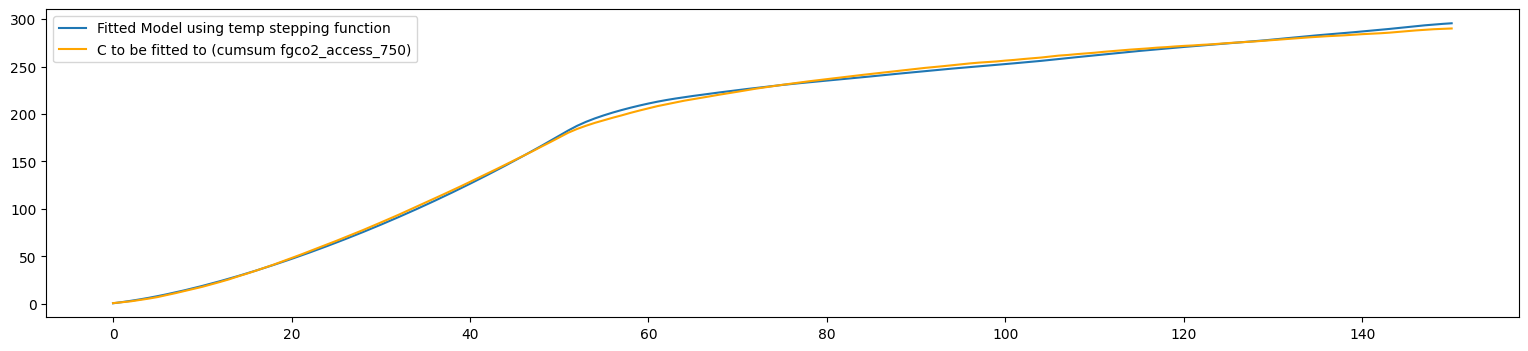

[[1.30176348 1.58389063 8.70484014]
 [0.17025176 2.48518685 9.79863418]]


In [383]:
# fitting function
def only_leave_params_to_be_set(time, alpha, beta, gamma, d_test= np.array([1,8,355])):
    q_test = np.array([0.2 * alpha, 0.3 * beta, 0.4 * gamma])  # q then d

    C_test_values = np.array(conc_access_750 - 280, dtype=float)
    C_output = np.zeros(len(C_test_values), dtype=float)

    S_test, C_output[0] = step_temperature_e(S_old=0, F=np.sum(C_test_values[0]), q=q_test, d=d_test, dt=1)

    for t in tqdm(range(1, len(time)), unit=' timestep'):
        S_test, C_output[t] = step_temperature_e(S_old=S_test, F=np.sum(C_test_values[t]), q=q_test, d=d_test, dt=1)

    return C_output.astype(float)


fgco2_access_750 = pd.read_csv('all_zecmip/ACCESS/ACCESS_A2/fgco2_ACCESS-ESM1.5_esm-1pct-brch-750PgC_54-153.csv', index_col=0)
F = fgco2_access_750[0:151]  # Truncate to 151 points
C_750 = np.cumsum(F).to_numpy().flatten() 

conc_access_750 = pd.read_csv('all_zecmip/ACCESS/ACCESS_A2/co2_ACCESS-ESM1.5_esm-1pct-brch-750PgC_54-153.csv', index_col=0)
conc_access_750 = conc_access_750.to_numpy().flatten()

# fit the curve
time = np.arange(len(conc_access_750))  # time array should also have 151 points

popt, pcov = curve_fit(only_leave_params_to_be_set, time, C_750, p0=[1, 1, 1])

# optimised parameters
alpha_opt_750, beta_opt_750, gamma_opt_750 = popt

# output C 
C_output_optimized_750 = only_leave_params_to_be_set(time, alpha_opt_750, beta_opt_750, gamma_opt_750)

# plot
fig, ax = plt.subplots(1, 1, figsize=(19, 4))

ax.plot(time, C_output_optimized_750, label='Fitted Model using temp stepping function')
ax.plot(time, C_750, 'orange', label='C to be fitted to (cumsum fgco2_access_750)')
ax.legend()

# optimised parameters
print("Optimised Parameters:")
print(f"alpha: {alpha_opt_750}, beta: {beta_opt_750}, gamma: {gamma_opt_750}")

plt.show()
newrow = np.array([alpha_opt_750, beta_opt_750, gamma_opt_750])
q_real = np.vstack([q_real, newrow])
print(q_real)

100%|███████████████████████████████| 213/213 [00:00<00:00, 63604.35 timestep/s]

Optimised Parameters:
alpha: 3.3917484644552243, beta: 1.600302064018874e-21, gamma: 4.60193216288772


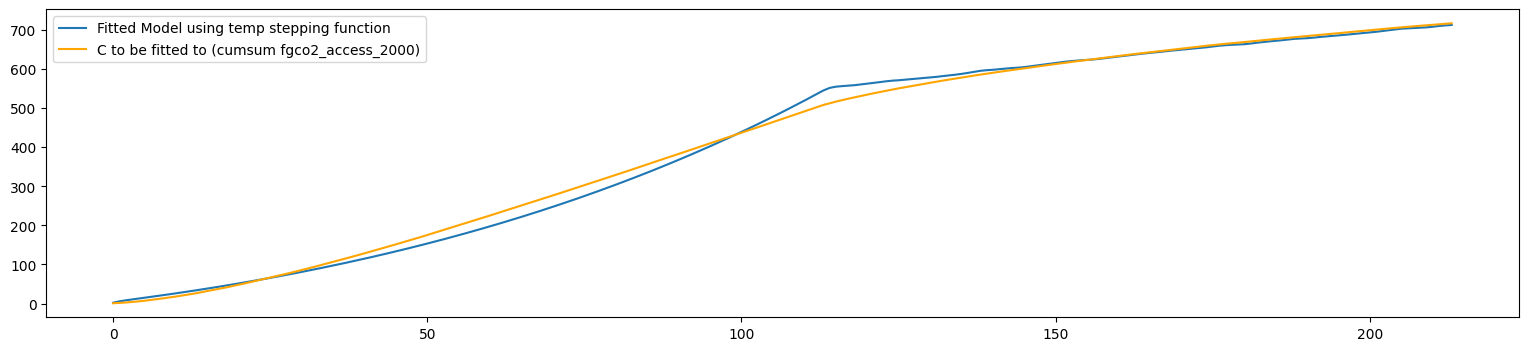

[[1.30176348e+00 1.58389063e+00 8.70484014e+00]
 [1.70251756e-01 2.48518685e+00 9.79863418e+00]
 [3.39174846e+00 1.60030206e-21 4.60193216e+00]]


In [384]:
# fitting function
def only_leave_params_to_be_set(time, alpha, beta, gamma, d_test= np.array([1,8,355])):
    q_test = np.array([0.2 * alpha, 0.3 * beta, 0.4 * gamma])  # q then d

    C_test_values = np.array(conc_access_2000 - 280, dtype=float)
    C_output = np.zeros(len(C_test_values), dtype=float)

    S_test, C_output[0] = step_temperature_e(S_old=0, F=np.sum(C_test_values[0]), q=q_test, d=d_test, dt=1)

    for t in tqdm(range(1, len(time)), unit=' timestep'):
        S_test, C_output[t] = step_temperature_e(S_old=S_test, F=np.sum(C_test_values[t]), q=q_test, d=d_test, dt=1)

    return C_output.astype(float)


fgco2_access_2000 = pd.read_csv('all_zecmip/ACCESS/ACCESS_A3/fgco2_ACCESS-ESM1.5_esm-1pct-brch-2000PgC_116-215.csv', index_col=0)
F = fgco2_access_2000  # Truncate to 151 points
C_2000 = np.cumsum(F).to_numpy().flatten() 

conc_access_2000 = pd.read_csv('all_zecmip/ACCESS/ACCESS_A3/co2_ACCESS-ESM1.5_esm-1pct-brch-2000PgC_116-215.csv', index_col=0)
conc_access_2000 = conc_access_2000.to_numpy().flatten()

# fit the curve
time = np.arange(len(conc_access_2000))  # time array should also have 151 points

bounds = (0, [np.inf, np.inf, np.inf])  # All q values must be >0, so lower bound is 0 and no upper limit

popt, pcov = curve_fit(only_leave_params_to_be_set, time, C_2000, p0=[1, 1, 1], bounds=bounds)

# optimised parameters
alpha_opt_2000, beta_opt_2000, gamma_opt_2000 = popt

# output C 
C_output_optimized_2000 = only_leave_params_to_be_set(time, alpha_opt_2000, beta_opt_2000, gamma_opt_2000)

# plot
fig, ax = plt.subplots(1, 1, figsize=(19, 4))

ax.plot(time, C_output_optimized_2000, label='Fitted Model using temp stepping function')
ax.plot(time, C_2000, 'orange', label='C to be fitted to (cumsum fgco2_access_2000)')
ax.legend()

# optimised parameters
print("Optimised Parameters:")
print(f"alpha: {alpha_opt_2000}, beta: {beta_opt_2000}, gamma: {gamma_opt_2000}")

plt.show()
newrow = np.array([alpha_opt_2000, beta_opt_2000, gamma_opt_2000])
q_real = np.vstack([q_real, newrow])
print(q_real)

100%|███████████████████████████████| 148/148 [00:00<00:00, 61791.46 timestep/s]

Optimised Parameters:
alpha: 4.046509079977062, beta: 4.629506265143776e-15, gamma: 9.773009235393974e-17


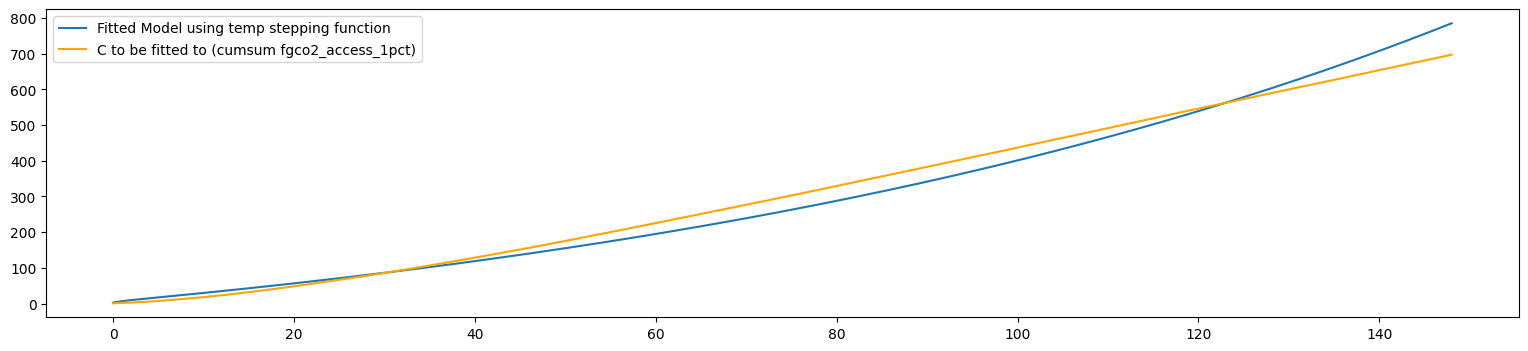

[[1.30176348e+00 1.58389063e+00 8.70484014e+00]
 [1.70251756e-01 2.48518685e+00 9.79863418e+00]
 [3.39174846e+00 1.60030206e-21 4.60193216e+00]
 [4.04650908e+00 4.62950627e-15 9.77300924e-17]]


In [385]:
# fitting function
def only_leave_params_to_be_set(time, alpha, beta, gamma, d_test= np.array([1,8,355])):
    q_test = np.array([0.2 * alpha, 0.3 * beta, 0.4 * gamma])  # q then d

    C_test_values = np.array(conc_access_1pct - 280, dtype=float)
    C_output = np.zeros(len(C_test_values), dtype=float)

    S_test, C_output[0] = step_temperature_e(S_old=0, F=np.sum(C_test_values[0]), q=q_test, d=d_test, dt=1)

    for t in tqdm(range(1, len(time)), unit=' timestep'):
        S_test, C_output[t] = step_temperature_e(S_old=S_test, F=np.sum(C_test_values[t]), q=q_test, d=d_test, dt=1)

    return C_output.astype(float)


fgco2_access_1pct = pd.read_csv('all_zecmip/ACCESS/ACCESS_1pct/fgco2_ACCESS-ESM1.5_A1_1-150.csv', index_col=0)
F = fgco2_access_1pct  # Truncate to 151 points
C_1pct = np.cumsum(F).to_numpy().flatten() 

conc_access_1pct = pd.read_csv('all_zecmip/ACCESS/ACCESS_1pct/co2_ACCESS-ESM1.5_A1_1-150.csv', index_col=0)
conc_access_1pct = conc_access_1pct.to_numpy().flatten()

# fit the curve
time = np.arange(len(conc_access_1pct))  # time array should also have 151 points

bounds = (0, [np.inf, np.inf, np.inf])  # All q values must be >0, so lower bound is 0 and no upper limit

popt, pcov = curve_fit(only_leave_params_to_be_set, time, C_1pct, p0=[1, 1, 1], bounds=bounds)

# optimised parameters
alpha_opt_1pct, beta_opt_1pct, gamma_opt_1pct = popt

# output C 
C_output_optimized_1pct = only_leave_params_to_be_set(time, alpha_opt_1pct, beta_opt_1pct, gamma_opt_1pct)

# plot
fig, ax = plt.subplots(1, 1, figsize=(19, 4))

ax.plot(time, C_output_optimized_1pct, label='Fitted Model using temp stepping function')
ax.plot(time, C_1pct, 'orange', label='C to be fitted to (cumsum fgco2_access_1pct)')
ax.legend()

# optimised parameters
print("Optimised Parameters:")
print(f"alpha: {alpha_opt_1pct}, beta: {beta_opt_1pct}, gamma: {gamma_opt_1pct}")

plt.show()
newrow = np.array([alpha_opt_1pct, beta_opt_1pct, gamma_opt_1pct])
q_real_access = np.vstack([q_real, newrow])
print(q_real_access)

In [386]:
# Define labels
labels = ['1000', '750', '2000', '1pct']

# Create a DataFrame
df_q_real_access = pd.DataFrame(q_real_access, columns=['q1', 'q2', 'q3'])
df_q_real_access['ACCESS DATASET'] = labels

# Display the DataFrame
print(df_q_real_access)

         q1            q2            q3 ACCESS DATASET
0  1.301763  1.583891e+00  8.704840e+00           1000
1  0.170252  2.485187e+00  9.798634e+00            750
2  3.391748  1.600302e-21  4.601932e+00           2000
3  4.046509  4.629506e-15  9.773009e-17           1pct


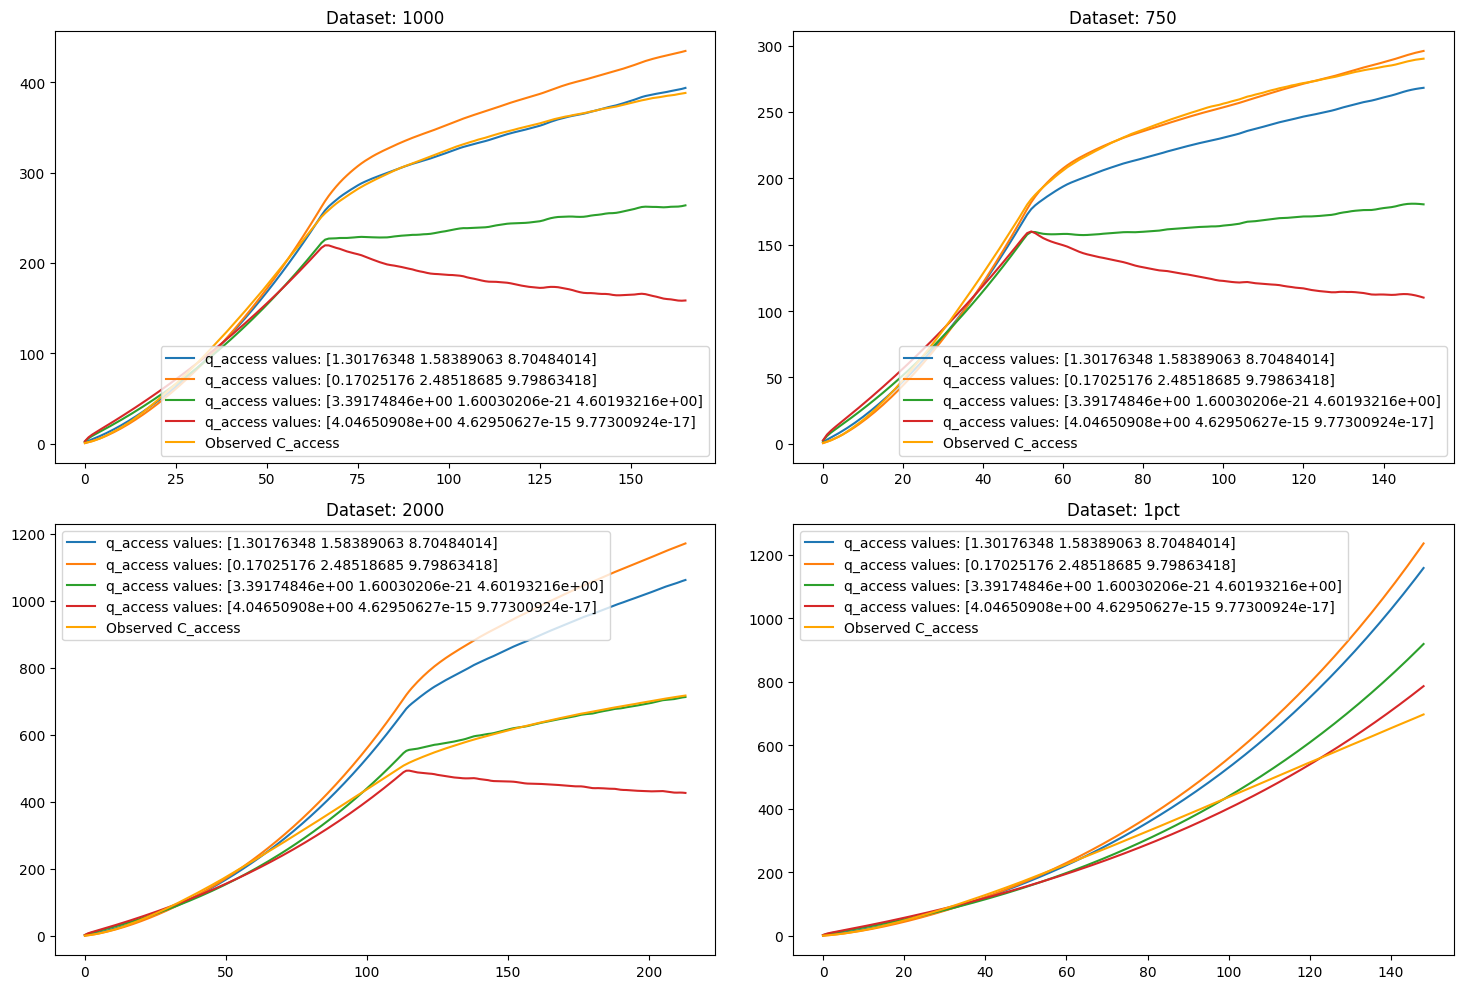

In [387]:
# Define the fitting function
def only_leave_params_to_be_set(time, alpha, beta, gamma, conc_access_data, d_test=np.array([0.9, 9.9, 355])):
    q_test = np.array([0.2 * alpha, 0.3 * beta, 0.4 * gamma])  # q values

    C_test_values = np.array(conc_access_data - 280, dtype=float)
    C_output = np.zeros(len(C_test_values), dtype=float)

    S_test, C_output[0] = step_temperature_e(S_old=0, F=np.sum(C_test_values[0]), q=q_test, d=d_test, dt=1)

    for t in range(1, len(C_test_values)):
        S_test, C_output[t] = step_temperature_e(S_old=S_test, F=np.sum(C_test_values[t]), q=q_test, d=d_test, dt=1)

    return C_output.astype(float)

datasets = ['1000', '750', '2000', '1pct']

fgco2_access = {
    '1000': pd.read_csv('all_zecmip/ACCESS/ACCESS_A1/fgco2_ACCESS-ESM1.5_esm-1pct-brch-1000PgC_68-167.csv', index_col=0).to_numpy().flatten(),
    '750': pd.read_csv('all_zecmip/ACCESS/ACCESS_A2/fgco2_ACCESS-ESM1.5_esm-1pct-brch-750PgC_54-153.csv', index_col=0).to_numpy().flatten(),
    '2000': pd.read_csv('all_zecmip/ACCESS/ACCESS_A3/fgco2_ACCESS-ESM1.5_esm-1pct-brch-2000PgC_116-215.csv', index_col=0).to_numpy().flatten(),
    '1pct': pd.read_csv('all_zecmip/ACCESS/ACCESS_1pct/fgco2_ACCESS-ESM1.5_A1_1-150.csv', index_col=0).to_numpy().flatten()
}

conc_access = {
    '1000': pd.read_csv('all_zecmip/ACCESS/ACCESS_A1/co2_ACCESS-ESM1.5_esm-1pct-brch-1000PgC_68-167.csv', index_col=0).to_numpy().flatten(),
    '750': pd.read_csv('all_zecmip/ACCESS/ACCESS_A2/co2_ACCESS-ESM1.5_esm-1pct-brch-750PgC_54-153.csv', index_col=0).to_numpy().flatten(),
    '2000': pd.read_csv('all_zecmip/ACCESS/ACCESS_A3/co2_ACCESS-ESM1.5_esm-1pct-brch-2000PgC_116-215.csv', index_col=0).to_numpy().flatten(),
    '1pct': pd.read_csv('all_zecmip/ACCESS/ACCESS_1pct/co2_ACCESS-ESM1.5_A1_1-150.csv', index_col=0).to_numpy().flatten()
}

# Create figure and axes
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax = ax.flatten()  # Flatten the 2D array of axes to 1D

for i, label in enumerate(datasets):
    fgco2 = fgco2_access[label]
    C = np.cumsum(fgco2)

    conc_data = conc_access[label]
    time = np.arange(len(conc_data))
    
    # Ensure consistent length for fitting
    min_length = min(len(C), len(conc_data))
    C = C[:min_length]
    conc_data = conc_data[:min_length]
    time = time[:min_length]

    # Fit the curve
    try:
        popt, _ = curve_fit(
            lambda time, alpha, beta, gamma: only_leave_params_to_be_set(time, alpha, beta, gamma, conc_data),
            time, C, p0=[1, 1, 1], bounds=(0, [np.inf, np.inf, np.inf])
        )
    except Exception as e:
        print(f"Error fitting curve for dataset {label}: {e}")
        continue
    
    # Optimized parameters
    alpha_opt, beta_opt, gamma_opt = popt
    
    # Output C 
    C_output_optimized = only_leave_params_to_be_set(time, alpha_opt, beta_opt, gamma_opt, conc_data)

    # Plot each set of q values
    for q_values in q_real_access:
        q_test = q_values
        C_output = only_leave_params_to_be_set(time, *q_values[:3], conc_data)  # Using q values
        
        # Ensure C_output is the same length as C
        if len(C_output) < len(C):
            C_output = np.pad(C_output, (0, len(C) - len(C_output)), 'constant', constant_values=np.nan)
        elif len(C_output) > len(C):
            C_output = C_output[:len(C)]

        ax[i].plot(time, C_output, label=f'q_access values: {q_values}')

    ax[i].plot(time, C, 'orange', label='Observed C_access')
    ax[i].set_title(f'Dataset: {label}')
    ax[i].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

Optimised Parameters:
alpha: 1.1238725431633583, beta: 1.5317151319213975, gamma: 8.291287863598036


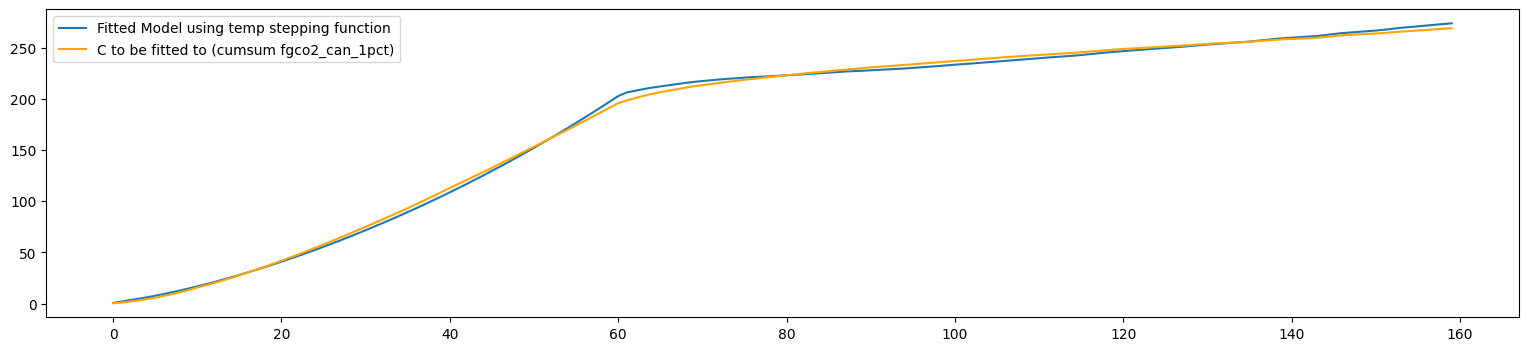

In [388]:
# Define the fitting function
def only_leave_params_to_be_set(time, alpha, beta, gamma, conc_access_data, d_test=np.array([0.9, 9.9, 355])):
    q_test = np.array([0.2 * alpha, 0.3 * beta, 0.4 * gamma])  # q values

    C_test_values = np.array(conc_access_data - 280, dtype=float)
    C_output = np.zeros(len(C_test_values), dtype=float)

    S_test, C_output[0] = step_temperature_e(S_old=0, F=np.sum(C_test_values[0]), q=q_test, d=d_test, dt=1)

    for t in range(1, len(C_test_values)):
        S_test, C_output[t] = step_temperature_e(S_old=S_test, F=np.sum(C_test_values[t]), q=q_test, d=d_test, dt=1)

    return C_output.astype(float)

# Load data
fgco2_can_1pct = pd.read_csv('all_zecmip/CanESM5/CanESM/fgco2_CanESM5_esm-1pct-brch-1000PgC_1851_2010.csv', index_col=0)
F = fgco2_can_1pct.to_numpy().flatten()
C_1pct = np.cumsum(F)

conc_can_1pct = pd.read_csv('all_zecmip/CanESM5/CanESM/co2_CanESM5_esm-1pct-brch-1000PgC_1851_2010.csv', index_col=0)
conc_can_1pct = conc_can_1pct.to_numpy().flatten()

# Define the time array
time = np.arange(len(conc_can_1pct))

# Define the function to fit
def model_func(time, alpha, beta, gamma):
    return only_leave_params_to_be_set(time, alpha, beta, gamma, conc_can_1pct)

# Fit the curve
bounds = (0, [np.inf, np.inf, np.inf])  # All q values must be >0, so lower bound is 0 and no upper limit

popt, _ = curve_fit(model_func, time, C_1pct, p0=[1, 1, 1], bounds=bounds)

# Optimized parameters
alpha_opt_1pct, beta_opt_1pct, gamma_opt_1pct = popt

# Output C 
C_output_optimized_1pct = only_leave_params_to_be_set(time, alpha_opt_1pct, beta_opt_1pct, gamma_opt_1pct, conc_can_1pct)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(19, 4))

ax.plot(time, C_output_optimized_1pct, label='Fitted Model using temp stepping function')
ax.plot(time, C_1pct, 'orange', label='C to be fitted to (cumsum fgco2_can_1pct)')
ax.legend()

# Print optimized parameters
print("Optimised Parameters:")
print(f"alpha: {alpha_opt_1pct}, beta: {beta_opt_1pct}, gamma: {gamma_opt_1pct}")

plt.show()

q_real_can = np.array([alpha_opt_1pct, beta_opt_1pct, gamma_opt_1pct])

ValueError: x and y must have same first dimension, but have shapes (196,) and (166,)

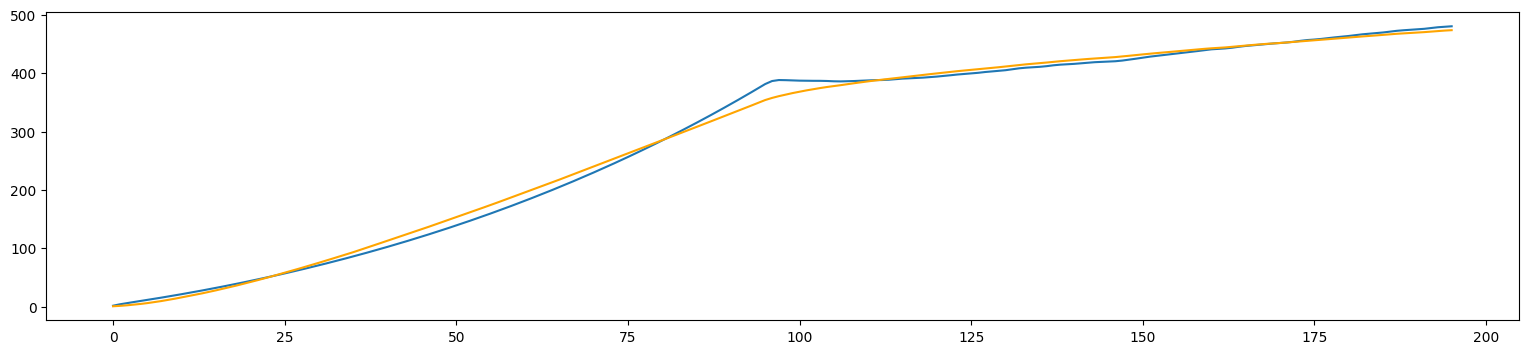

In [391]:
# Define the fitting function
def only_leave_params_to_be_set(time, alpha, beta, gamma, conc_access_data, d_test=np.array([0.9, 9.9, 355])):
    q_test = np.array([0.2 * alpha, 0.3 * beta, 0.4 * gamma])  # q values

    C_test_values = np.array(conc_access_data - 280, dtype=float)
    C_output = np.zeros(len(C_test_values), dtype=float)

    S_test, C_output[0] = step_temperature_e(S_old=0, F=np.sum(C_test_values[0]), q=q_test, d=d_test, dt=1)

    for t in range(1, len(C_test_values)):
        S_test, C_output[t] = step_temperature_e(S_old=S_test, F=np.sum(C_test_values[t]), q=q_test, d=d_test, dt=1)

    return C_output.astype(float)

# Load data
fgco2_can_1pct_2000 = pd.read_csv('all_zecmip/CanESM5/CanESM/fgco2_CanESM5_esm-1pct-brch-2000PgC_1947_2010.csv', index_col=0)
F = fgco2_can_1pct_2000.to_numpy().flatten()
C_1pct_2000 = np.cumsum(F)

conc_can_1pct_2000 = pd.read_csv('all_zecmip/CanESM5/CanESM/co2_CanESM5_esm-1pct-brch-2000PgC_1947_2010.csv', index_col=0)
conc_can_1pct_2000 = conc_can_1pct_2000.to_numpy().flatten()

# Define the time array
time = np.arange(len(conc_can_1pct_2000))

# Define the function to fit
def model_func(time, alpha, beta, gamma):
    return only_leave_params_to_be_set(time, alpha, beta, gamma, conc_can_1pct_2000)

# Fit the curve
bounds = (0, [np.inf, np.inf, np.inf])  # All q values must be >0, so lower bound is 0 and no upper limit

popt, _ = curve_fit(model_func, time, C_1pct_2000, p0=[1, 1, 1], bounds=bounds)

# Optimized parameters
alpha_opt_1pct_2000, beta_opt_1pct_2000, gamma_opt_1pct_2000 = popt

# Output C 
C_output_optimized_1pct_2000 = only_leave_params_to_be_set(time, alpha_opt_1pct_2000, beta_opt_1pct_2000, gamma_opt_1pct_2000, conc_can_1pct_2000)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(19, 4))

ax.plot(time, C_output_optimized_1pct_2000, label='Fitted Model using temp stepping function')
ax.plot(time, C_1pct_2000, 'orange', label='C to be fitted to (cumsum fgco2_can_1pct_2000)')
ax.plot(time, C_output_optimized_1000[:len(C_1pct_2000)], label='Fitted Model using temp stepping function')
ax.plot(time, C_1000[:C_1pct_2000], 'orange', label='C to be fitted to (cumsum fgco2_access)')
ax.legend()

# print optimised parameters
print("Optimised Parameters ACCESS:")
print(f"alpha: {alpha_opt_1000}, beta: {beta_opt_1000}, gamma: {gamma_opt_1000}")

# Print optimized parameters
print("Optimised Parameters CanESM5:")
print(f"alpha: {alpha_opt_1pct_2000}, beta: {beta_opt_1pct_2000}, gamma: {gamma_opt_1pct_2000}")

plt.show()

q_real_can = np.vstack([q_real_can, [alpha_opt_1pct, beta_opt_1pct, gamma_opt_1pct]])